In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent.parent
DIR_PATH = Path().resolve()
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))

In [ ]:
from glob import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import PyPDF2
import soundfile as sf
from frequency_response import FrequencyResponse
from biquad import digital_coeffs, peaking
from research.limited_gradient_smoothing.utils import log_log_gradient, limited_slope, limited_slope_plots

## Frequency Response Creation Utils

In [ ]:
onear_target = ROOT_PATH.joinpath('compensation/harman_over-ear_2018.csv')
inear_target = ROOT_PATH.joinpath('compensation/harman_in-ear_2019v2.csv')
rtings_onear_target = ROOT_PATH.joinpath('measurements/rtings/resources/rtings_harman_over-ear_2018.csv')
rtings_inear_target = ROOT_PATH.joinpath('measurements/rtings/resources/rtings_harman_in-ear_2019v2.csv')

In [ ]:
def iir_fr(fc, Q, gain):
    fs = 48000
    fr = FrequencyResponse(name='peaking')
    fr.raw = np.zeros(fr.frequency.shape)
    for __fc, __Q, __gain in zip(fc, Q, gain):
        a0, a1, a2, b0, b1, b2 = peaking(__fc, __Q, __gain, fs=fs)
        fr.raw += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
    return fr

def equalization(measurement_path, target_path):
    fr = FrequencyResponse.read_from_csv(measurement_path)
    target = FrequencyResponse.read_from_csv(target_path)
    fr.compensate(target)
    return fr

def write_fir(fr, name_suffix=''):
    ir = fr.minimum_phase_impulse_response(fs=48000, f_res=5, normalize=True)
    DIR_PATH.joinpath('fir').mkdir(exist_ok=True)
    sf.write(
        DIR_PATH.joinpath('fir', f'{fr.name}{name_suffix}.wav'),
        np.tile(ir, (2, 1)).T,
        48000, 'PCM_16'
    )
    
def write_graphic_eq(fr, name_suffix=''):
    DIR_PATH.joinpath('graphiceq').mkdir(exist_ok=True)
    s = fr.write_eqapo_graphic_eq(DIR_PATH.joinpath('graphiceq', f'{fr.name}{name_suffix}.txt'), normalize=True)
    
def write_img(fr, fig, name_suffix=''):
    DIR_PATH.joinpath('img').mkdir(exist_ok=True)
    fig.savefig(DIR_PATH.joinpath('img', f'{fr.name}{name_suffix}.png'))

def process(measurement_path, target_path, limit, limit_decay=0.0, xlim=None, show=True):
    fr = equalization(measurement_path, target_path)
    fr.equalization = -fr.error
    limited, _, _, _, _, _, _, _, _, _ = limited_slope(fr.frequency, fr.equalization, limit, limit_decay=limit_decay)
    fig, ax = limited_slope_plots(fr, limit, limit_decay=limit_decay)
    if xlim is not None:
        ax.set_xlim(xlim)
    write_img(fr, fig, name_suffix=f' {limit}')
    if show:
        plt.show()
    fr.equalization = limited
    #write_graphic_eq(fr, name_suffix=f' {limit}')
    #write_fir(fr, name_suffix=f' {limit}')
    plt.close()

## Limited Delta Algorith
This algorithm avoids peaks by limiting the delta (derivative) of a function.

1. Curve is traversed in both directions, gradients are limited and a minimum is taken
2. 9 kHz notch is avoided with 25% max slope (18 dB -> 4.5 dB) between 8 kHz and 11.5 kHz
3. Limited regions which don't overlap peaks are removed
4. Dips which are lower in level than their adjacent dips are limitation free zones

#### TODO
- Fix trend by comparing super heavy smoothed EQ FRs?
  - 9 kHz region must be excluded from the trends because it's missing from the targets
- 9 kHz region limit
- 9 kHz region starts and ends with the 9 kHz peak?
- No 9 kHz region for IEMs

## Problematic

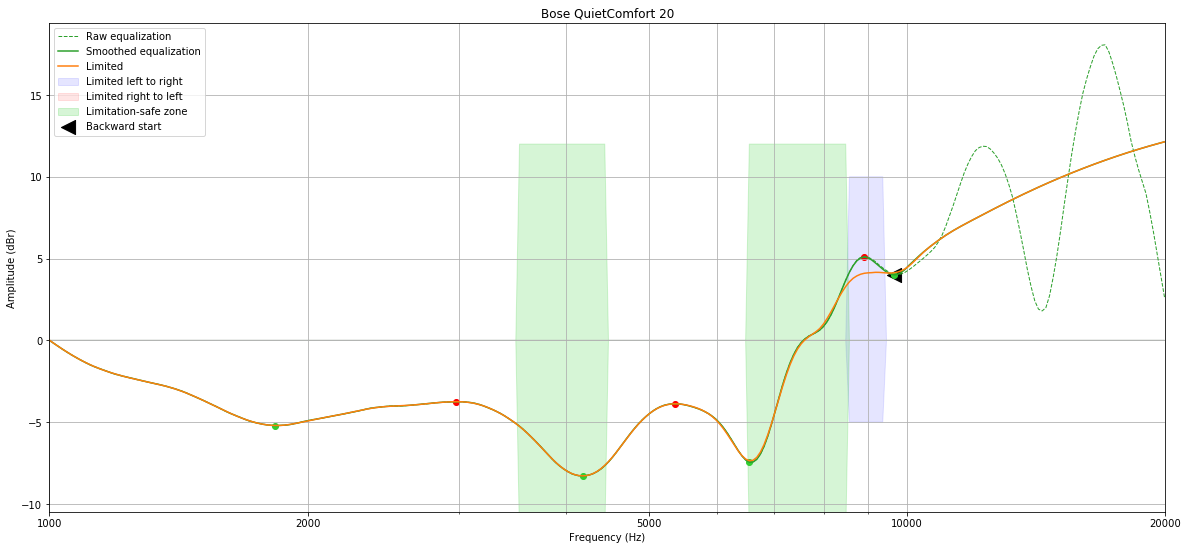

In [181]:
# There's no 9 kHz peak
process(ROOT_PATH.joinpath('measurements/rtings/data/onear/Bose QuietComfort 20/Bose QuietComfort 20.csv'), rtings_onear_target, 18, xlim=[1000, 20000])

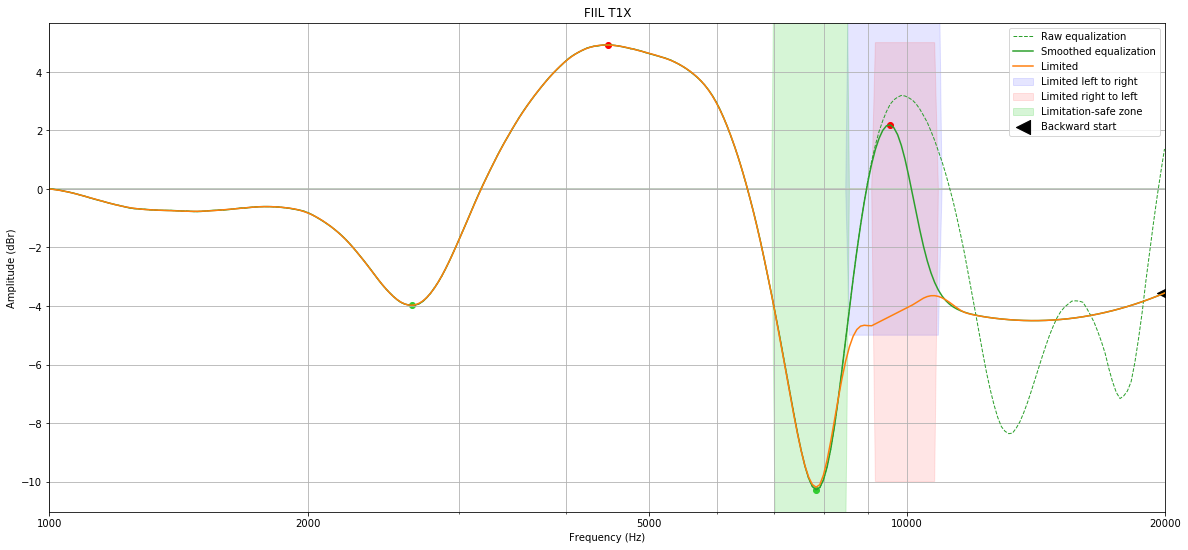

In [182]:
process(ROOT_PATH.joinpath('measurements/rtings/data/inear/FIIL T1X/FIIL T1X.csv'), rtings_inear_target, 18, xlim=[1000, 20000])

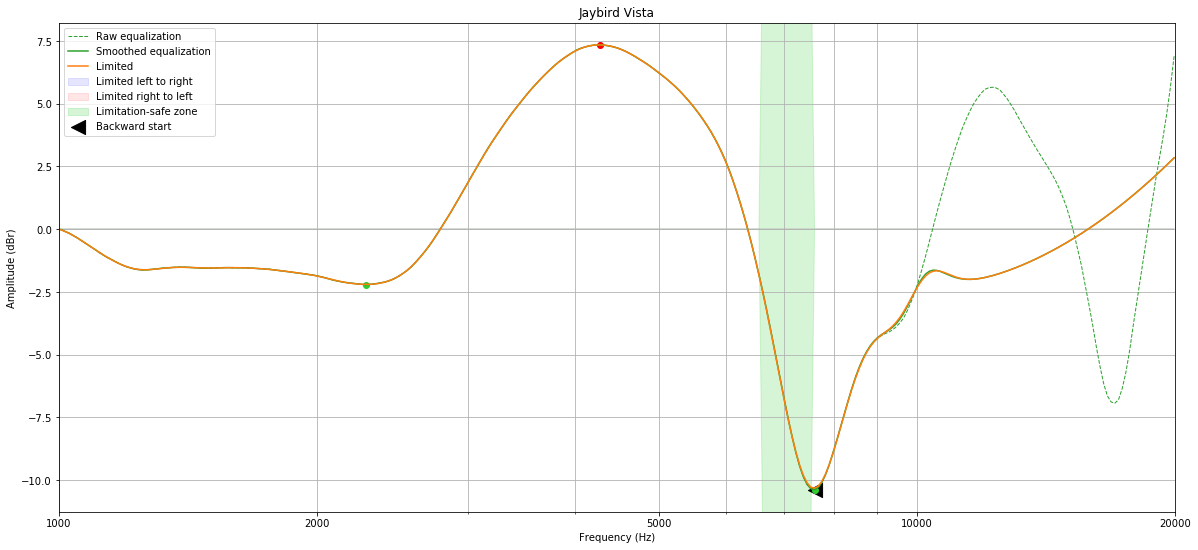

In [183]:
process(ROOT_PATH.joinpath('measurements/rtings/data/inear/Jaybird Vista/Jaybird Vista.csv'), rtings_inear_target, 18, xlim=[1000, 20000])

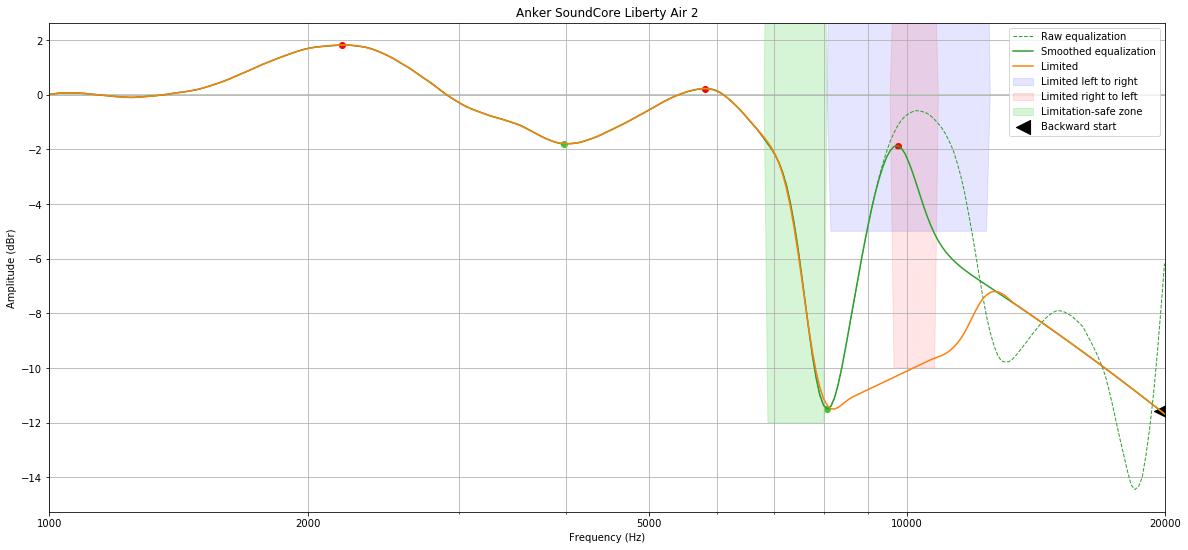

In [184]:
process(ROOT_PATH.joinpath('measurements/rtings/data/inear/Anker SoundCore Liberty Air 2/Anker SoundCore Liberty Air 2.csv'), rtings_inear_target, 18, xlim=[1000, 20000])

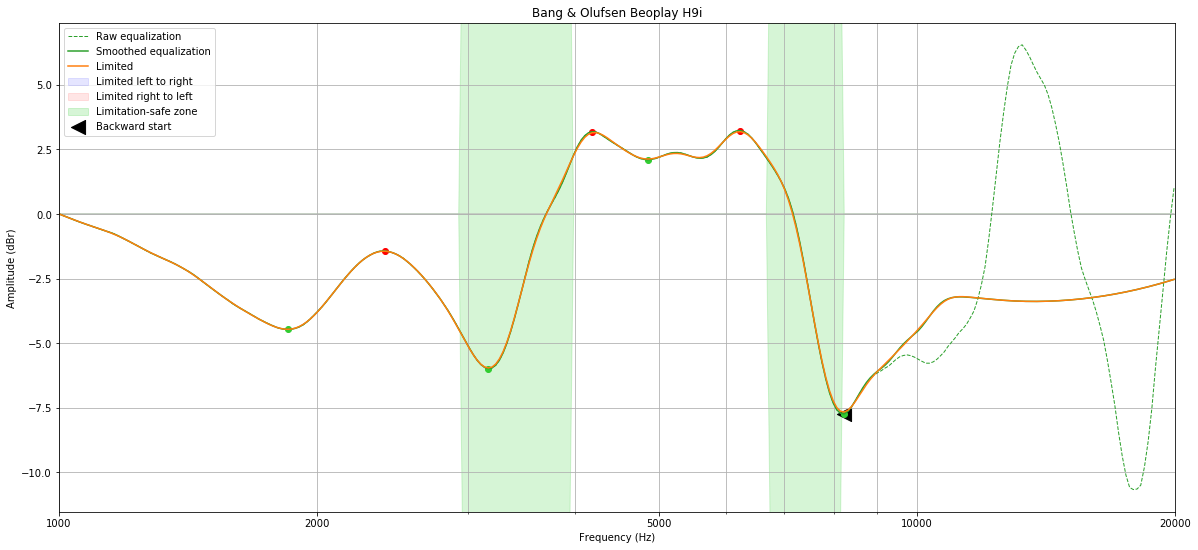

In [197]:
# 3.5 kHz L2R and 7.5 kHz R2L rises are sharp and not limited because of the dip at 5 kHz
process(ROOT_PATH.joinpath('measurements/rtings/data/onear/Bang & Olufsen Beoplay H9i/Bang & Olufsen Beoplay H9i.csv'), rtings_onear_target, 18, xlim=[1000, 20000])

## Interesting

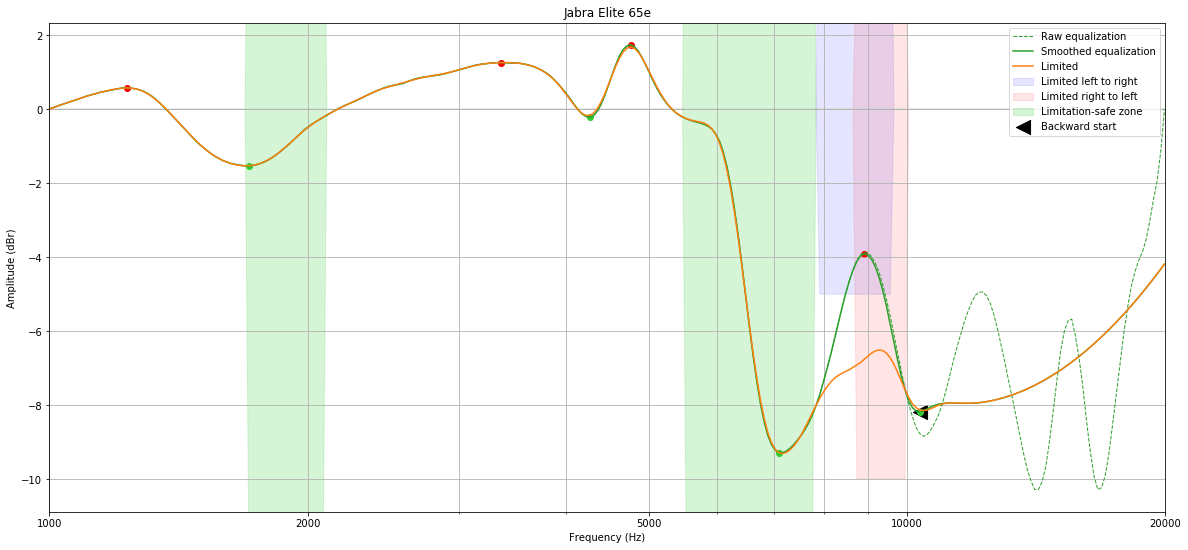

In [185]:
# Limitation-free zone allows very steep R2L rise from 7 kHz
process(ROOT_PATH.joinpath('measurements/rtings/data/inear/Jabra Elite 65e/Jabra Elite 65e.csv'), rtings_inear_target, 18, xlim=[1000, 20000])

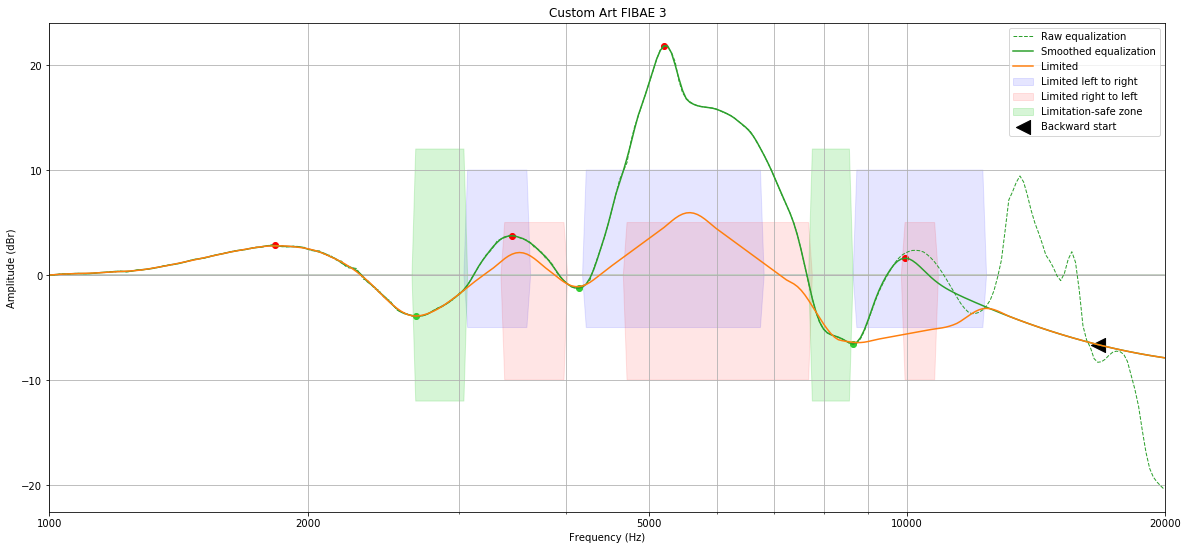

In [186]:
# Massive dip in the frequency response betweeen 5 and 7 kHz
# Attempts to equalize will produce sizzling while having veiled vocals at the same time
process(ROOT_PATH.joinpath('measurements/crinacle/data/inear/Custom Art FIBAE 3/Custom Art FIBAE 3.csv'), inear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

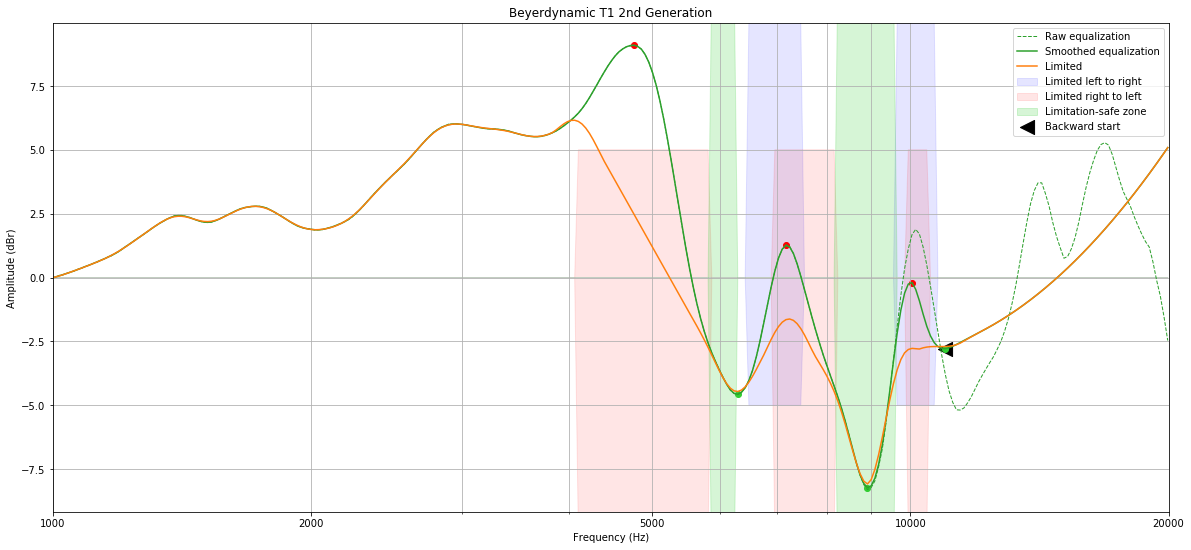

In [187]:
# Beyerdynamic T1 2nd Generation has a prominent peak at 4800 Hz but is only limited from R2L
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Beyerdynamic T1 2nd Generation/Beyerdynamic T1 2nd Generation.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

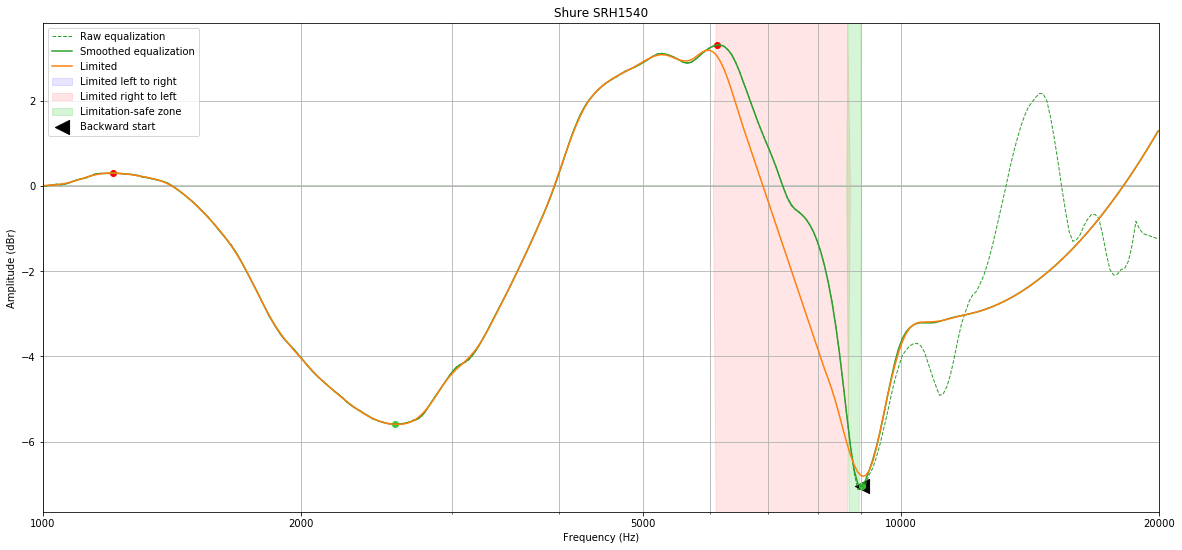

In [188]:
# 9 kHz dip is limited by left side but this would not happen when using minimum of the both side limitations and the right side target would be set right after 10 khz
# Treating the protection zone targets separately for both sides would result in limiting the left side because the adjacent dip is -5.5 dB at 2600 Hz
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Shure SRH1540/Shure SRH1540.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

## Solved

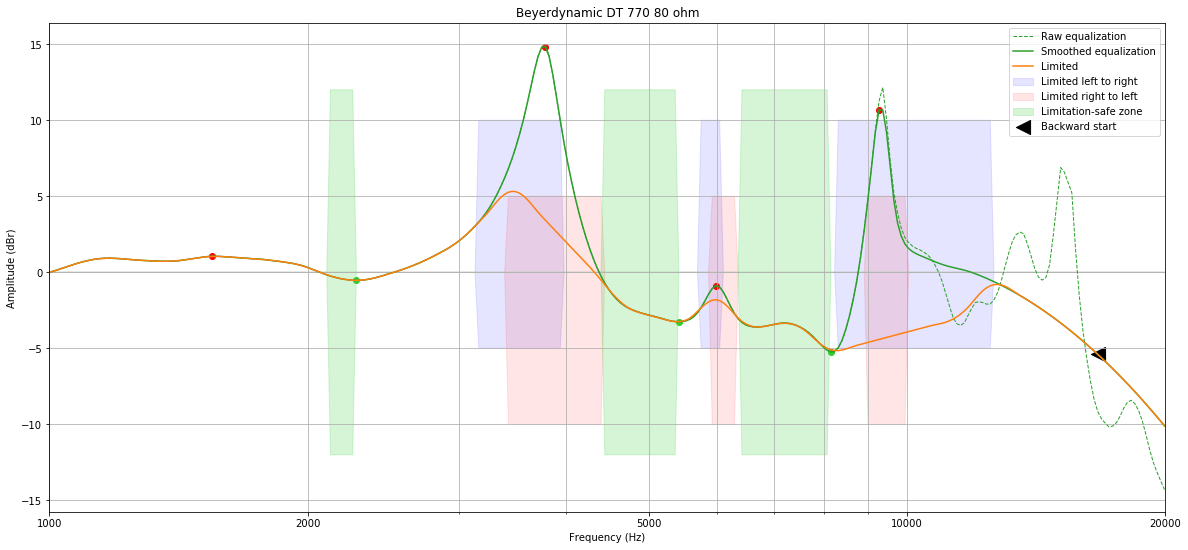

In [189]:
# Beyerdynamic DT 770 80 ohm behaves quite nicely when equalization peaks are limited
process(ROOT_PATH.joinpath('measurements/crinacle/data/onear/GRAS 43AG-7/Beyerdynamic DT 770 80 ohm/Beyerdynamic DT 770 80 ohm.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

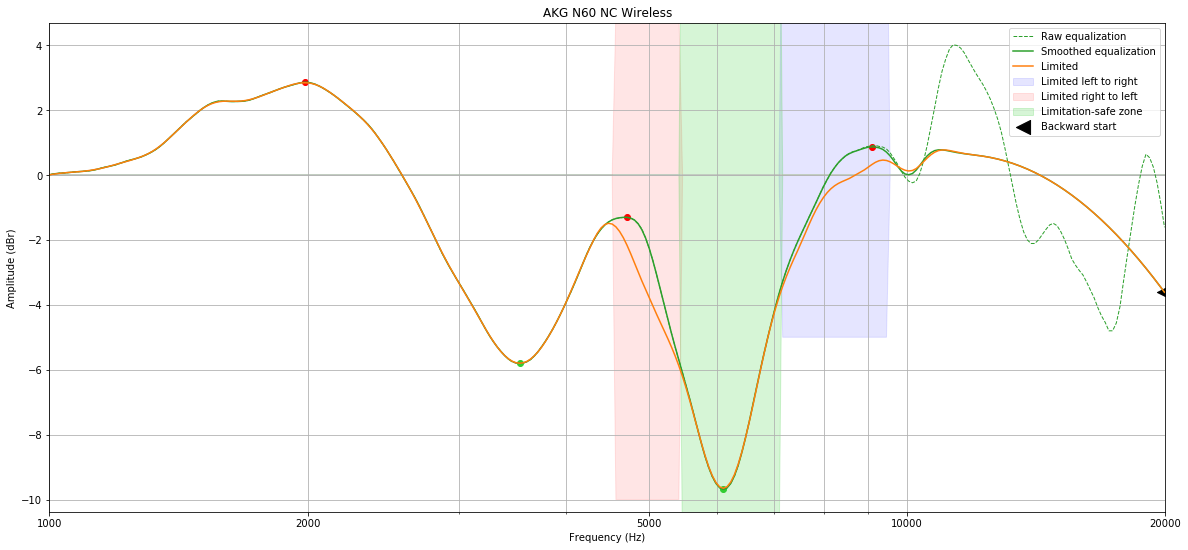

In [190]:
# Right side of 6 kHz dip is unnecessarily limited. Protection zone should extend to -4 dB at least.
# FIXED by adding 20 kHz level as the last dip when the last peak comes after the last dip.
process(ROOT_PATH.joinpath('measurements/rtings/data/onear/AKG N60 NC Wireless/AKG N60 NC Wireless.csv'), rtings_onear_target, 18, xlim=[1000, 20000])

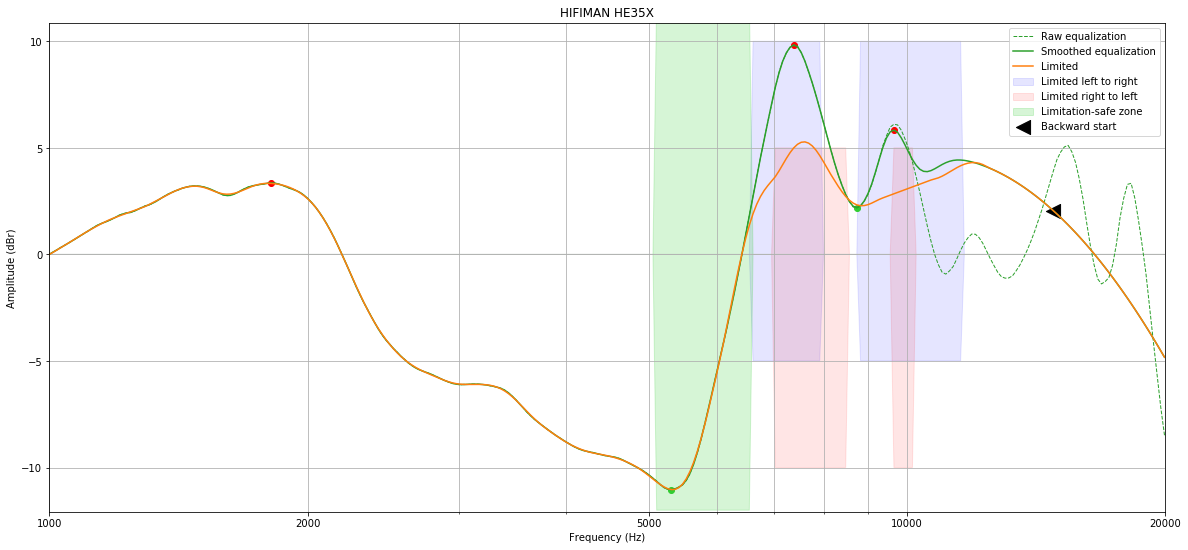

In [191]:
# 5200 Hz dip is limited by right side because adjacent left side notch is similar in level
# Protection level should perhaps extend to 6600 Hz
# FIXED by limitation-free zones
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/HIFIMAN HE35X/HIFIMAN HE35X.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

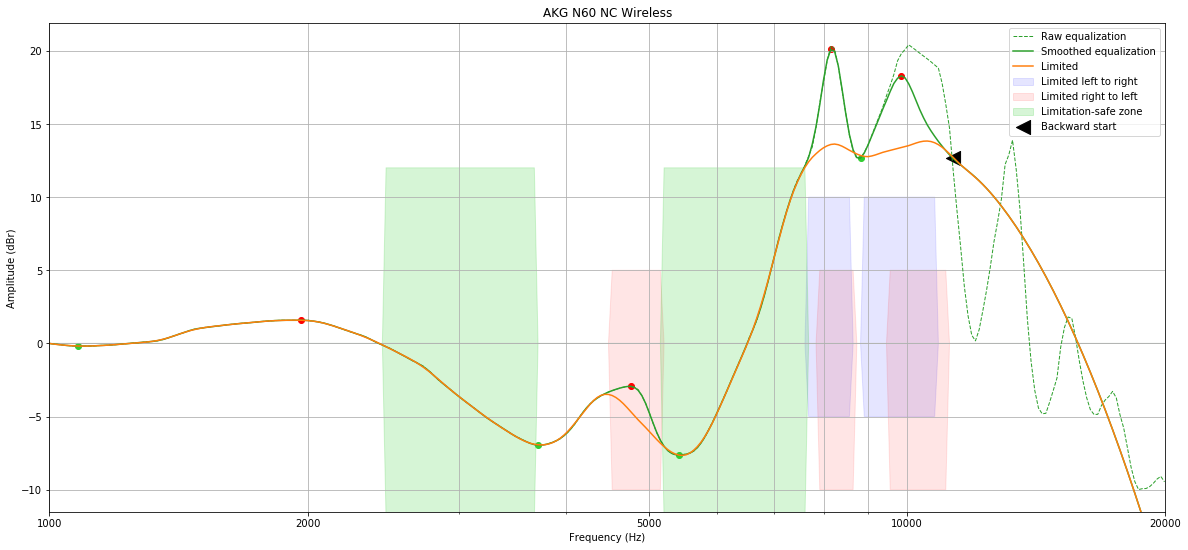

In [192]:
# Backward start is a problem here when starting at 20 kHz because of the significant high frequency roll-off
# FIXED by backward start search algorithm
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG N60 NC Wireless/AKG N60 NC Wireless.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

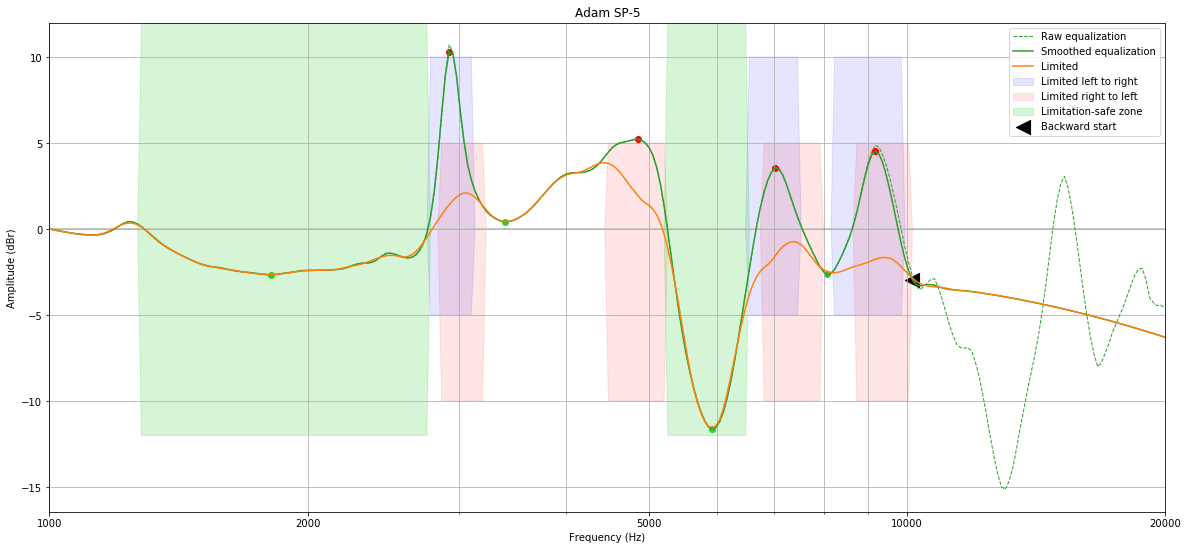

In [193]:
# Adam SP-5 has an elevation between 4 and 6 kHz but is limited only from R2L.
# The right side slope is shared by the following notch at 6 kHz.
# 6 kHz notch could be left alone between 5.2 kHz and 6.5 kHz
# FIXED by limitation-safe zones
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Adam SP-5/Adam SP-5.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

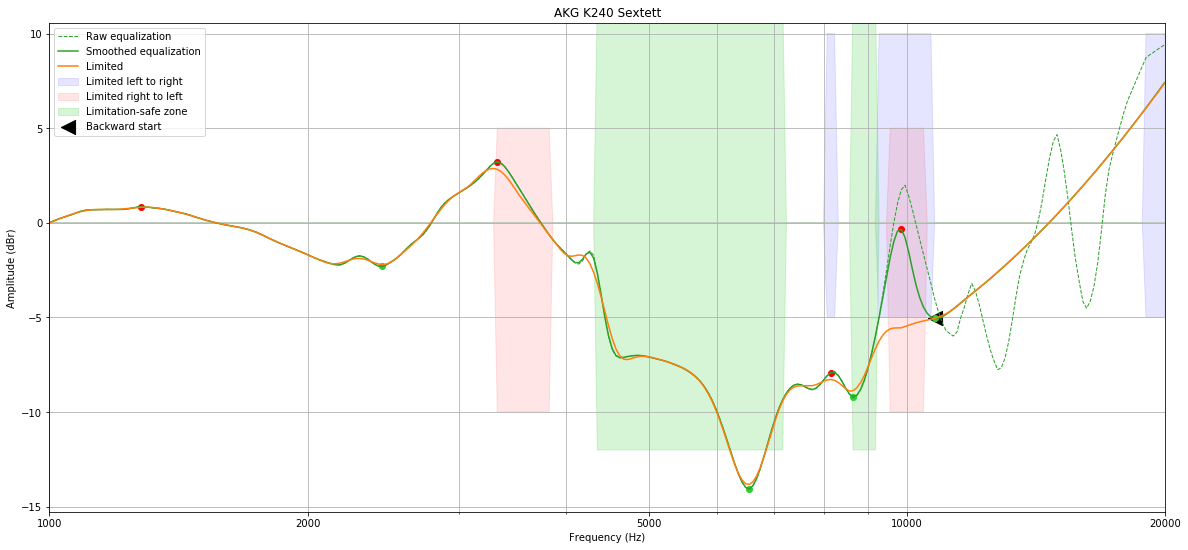

In [194]:
# 4200 Hz peak is limited from one side only
# Right side of 6.5 kHz notch is limited because of the miniscule 8.1 kHz peak.
# Limitation-free zone prevents limitation on both sides BUT should it?
# FIXED by limitation-safe zones
process(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG K240 Sextett/AKG K240 Sextett.csv'), onear_target, 18, limit_decay=0.0, xlim=[1000, 20000])

## Mass Images

In [ ]:
img_path = ROOT_PATH.joinpath('research', 'limited_gradient_smoothing', 'img')
img_path.mkdir(exist_ok=True)
for fp in ROOT_PATH.glob('measurements/oratory1990/data/onear/**/*.csv'):
    process(fp, onear_target, 18, xlim=[1000, 20000], show=False)

In [ ]:
for fp in ROOT_PATH.glob('measurements/crinacle/data/onear/GRAS 43AG-7/**/*.csv'):
    process(fp, onear_target, 18, xlim=[1000, 20000], show=False)

In [ ]:
for fp in ROOT_PATH.glob('measurements/crinacle/data/inear/**/*.csv'):
    process(fp, inear_target, 18, xlim=[1000, 20000], show=False)

In [195]:
rtings_onear_target = ROOT_PATH.joinpath('measurements/rtings/resources/rtings_harman_over-ear_2018.csv')
rtings_inear_target = ROOT_PATH.joinpath('measurements/rtings/resources/rtings_harman_in-ear_2019v2.csv')
for fp in ROOT_PATH.glob('measurements/rtings/data/onear/**/*.csv'):
    process(fp, rtings_onear_target, 18, xlim=[1000, 20000], show=False)
for fp in ROOT_PATH.glob('measurements/rtings/data/inear/**/*.csv'):
    process(fp, rtings_inear_target, 18, xlim=[1000, 20000], show=False)